In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import suppress

### run regression model

In [2]:
# load data
cd = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
shp = gpd.read_file(cd + "/icrisat_boundary_match.shp")[['NAME_1', 'Name_12', 'Dist_Name', 'Shape_Area', 'geometry']]
df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]
df = df_raw[(df_raw["year"].between(2000, 2022)) & df_raw["yield"].notna() & np.isfinite(df_raw["yield"])]

# Run regression and generate predictions
regs = []
yield_mean = df["yield"].mean(skipna=True)
for (cropname, name_1, name_12), group in df.groupby(["cropname", "NAME_1", "Name_12"]):
    if len(group) >= 10 and not group["sm"].isna().all() and not group["tmax"].isna().all():
        X = group[["sm", "tmax", "year"]].dropna()
        y = np.log(group.loc[X.index, "yield"] + yield_mean)

        model = sm.OLS(y, sm.add_constant(X)).fit()
        predictions = pd.DataFrame({
            "year": X["year"],
            "predicted_yield": np.exp(model.predict(sm.add_constant(X))) - yield_mean
        })

        regs.append({
            "cropname": cropname,
            "NAME_1": name_1,
            "Name_12": name_12,
            "r2": model.rsquared,
            "sm_slope": model.params.get("sm", np.nan),
            "tmax_slope": model.params.get("tmax", np.nan),
            "year_slope": model.params.get("year", np.nan),
            "sm_pval": model.pvalues.get("sm", np.nan),
            "tmax_pval": model.pvalues.get("tmax", np.nan),
            "year_pval": model.pvalues.get("year", np.nan),
            "predictions": predictions
        })

regs_df = pd.DataFrame(regs)
regs_df = regs_df[regs_df["r2"] < 1]  

/var/folders/k4/2gcvspsj7d7c9hbxlvzv_zrh0000gn/T/ipykernel_31705/2797683829.py:4: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


### fxs for plotting

In [3]:
regs_plot = shp.merge(regs_df, on="Name_12", how="left").dropna(subset=["cropname"])

In [9]:
def plot_facet_maps(data, fill_var, title, cmap, color_var=None, color_threshold=None, vmin=None, vmax=None):
    unique_crops = data["cropname"].unique()
    num_crops = len(unique_crops)

    cols = min(num_crops, 3)  # Limit to 3 columns
    rows = (num_crops // cols) + (num_crops % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten() if num_crops > 1 else [axes]

    for i, crop in enumerate(unique_crops):
        ax = axes[i]
        crop_data = data[data["cropname"] == crop]

        crop_data.plot(column=fill_var, cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0.5, edgecolor="none", ax=ax, legend=True)

        if color_var:
            significant = crop_data[crop_data[color_var] < color_threshold]
            significant.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

        ax.set_title(f"{title} - {crop}", fontsize=14)
        ax.axis("off")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

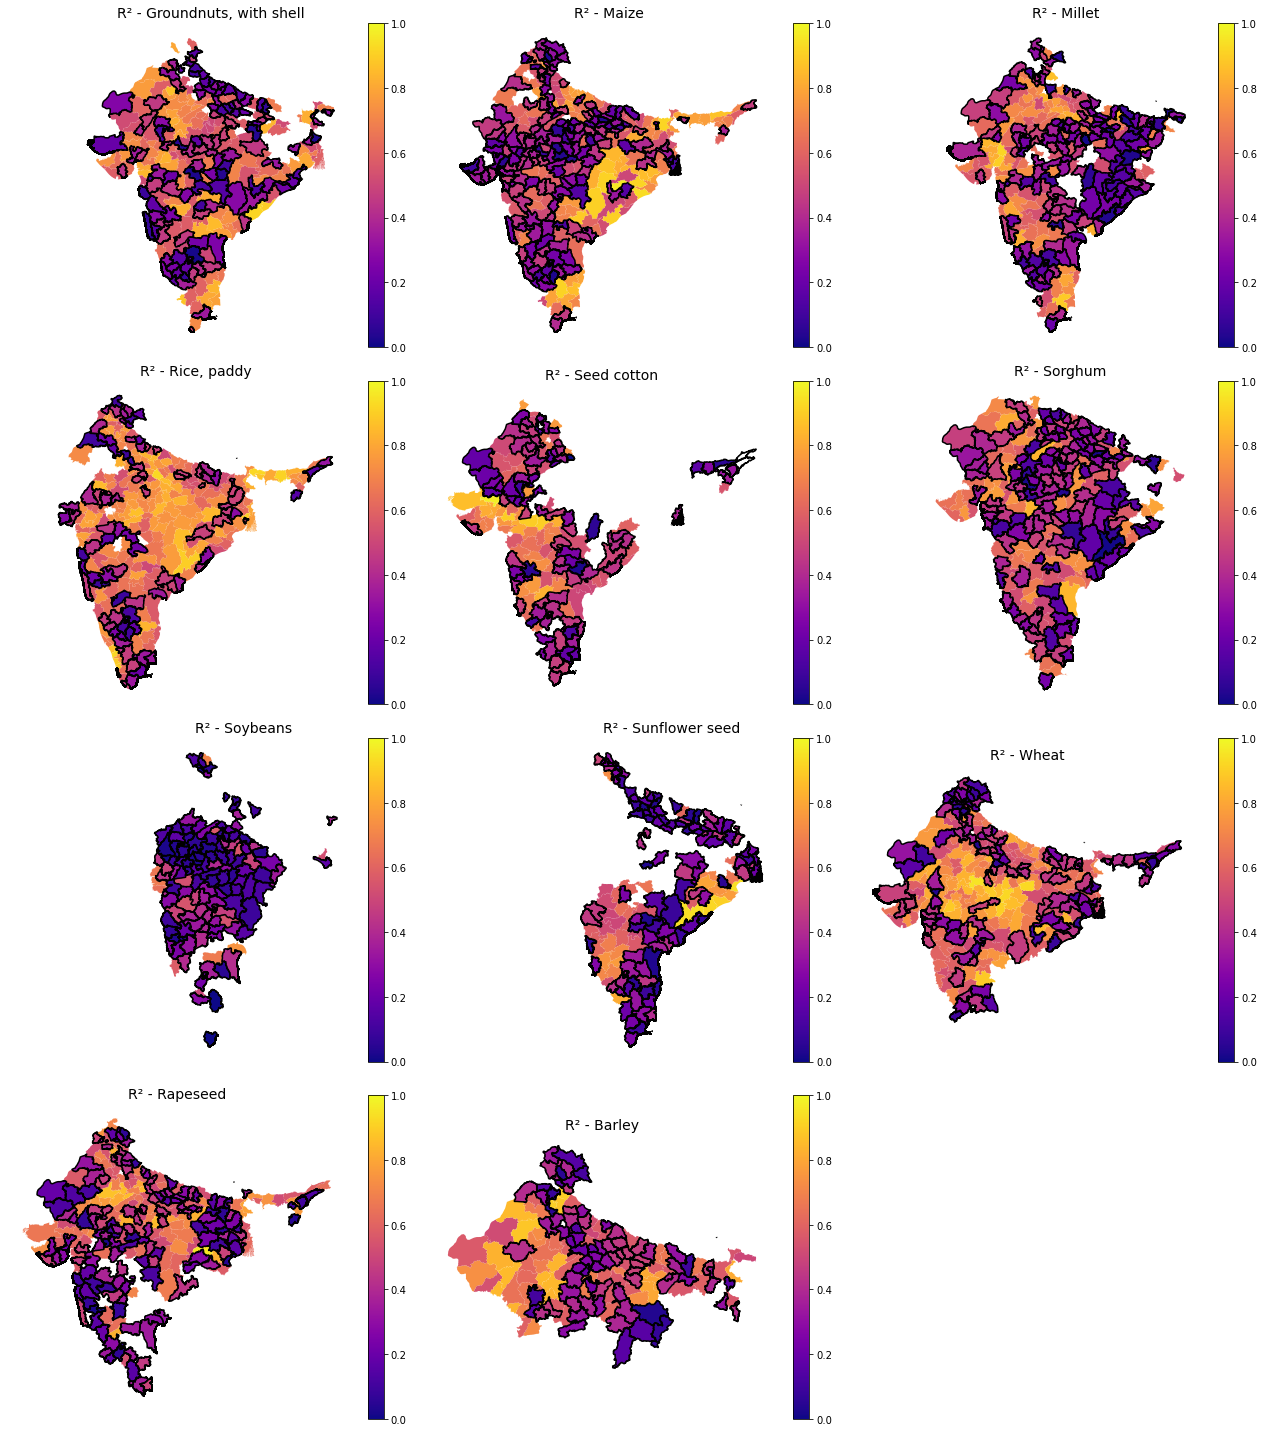

In [10]:
# Plot R²
plot_facet_maps(
    regs_plot,
    fill_var="r2",
    title="R²",
    cmap="plasma",
    color_var="r2",
    vmin=0,
    vmax=1,
    color_threshold=0.5)

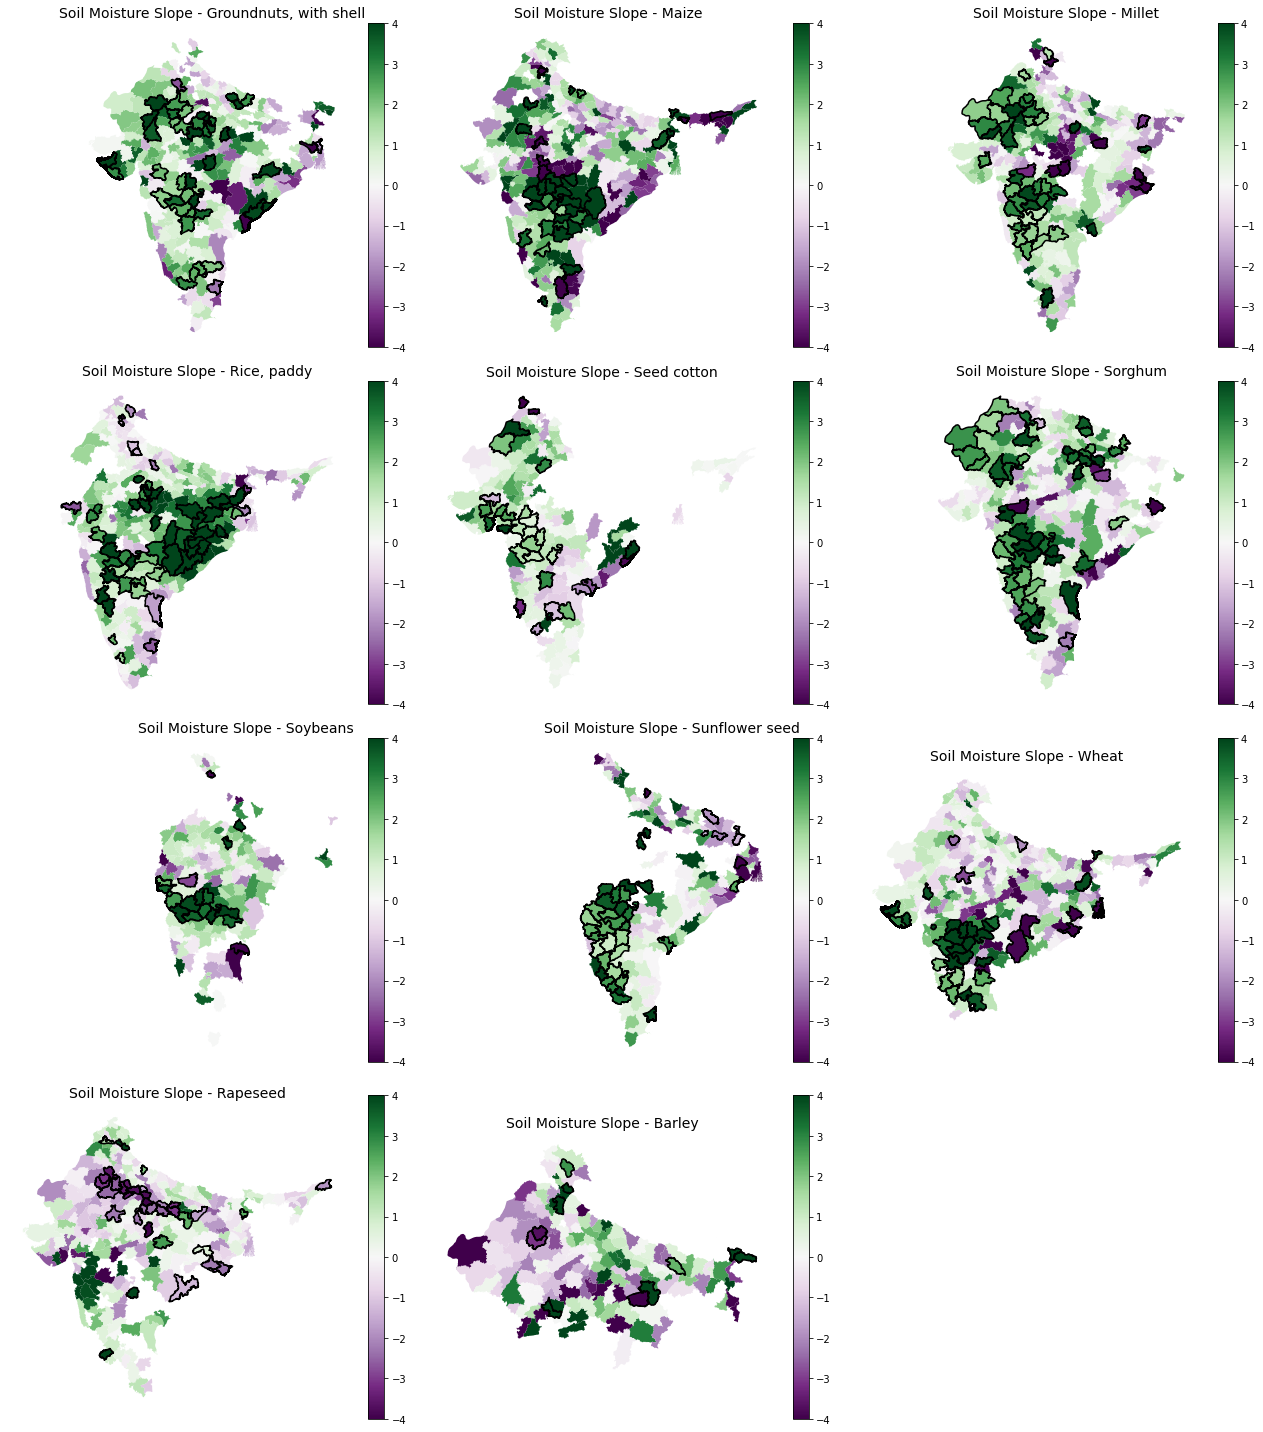

In [11]:
# Plot Soil Moisture Slope
plot_facet_maps(
    regs_plot,
    fill_var="sm_slope",
    title="Soil Moisture Slope",
    cmap="PRGn",
    color_var="sm_pval",
    color_threshold=0.05,
    vmin=-4,
    vmax=4)

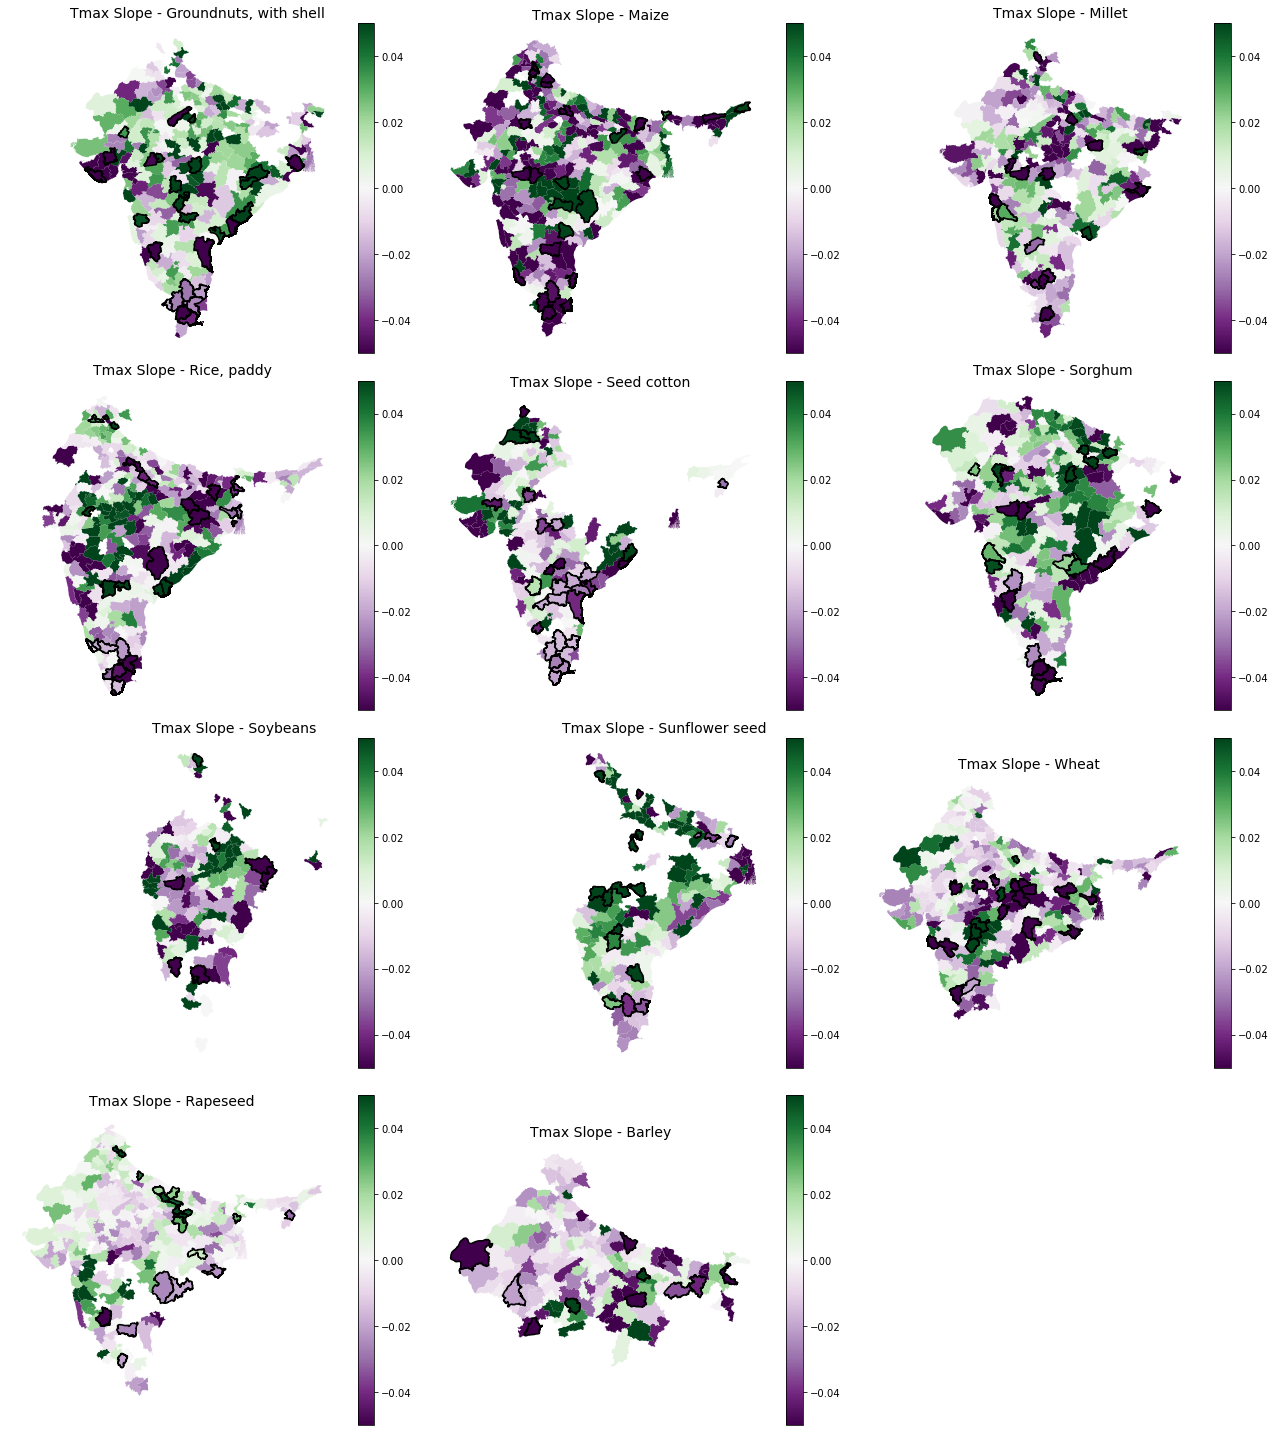

In [12]:
# Plot Tmax Slope
plot_facet_maps(
    regs_plot,
    fill_var="tmax_slope",
    title="Tmax Slope",
    cmap="PRGn",
    color_var="tmax_pval",
    color_threshold=0.05,
    vmin=-0.05,
    vmax=0.05)